In [382]:
import numpy as np
import matplotlib.pyplot as plt
import math as m
import copy
import cmath as cm
import time as t
from matplotlib.animation import FuncAnimation
import sympy
from fractions import Fraction

In [285]:
## Prints a state with binary output
def PrettyPrintBinary(myState, do_return=False):
    to_print = "{ "
    vec = StateToVec(myState)
    length = vec.shape[0]
    bin_len = int(m.log2(length))
    not_first = False
    for i in range(length):
        if vec[i] == 0 + 0.j:
            continue
        if not_first:
            to_print += " + "
        to_print += f"{vec[i]} |{bin(i)[2:].zfill(bin_len)}>"
        not_first = True
    to_print += "}"
    if do_return: return to_print
    print(to_print)

## Prints a state with integer output
def PrettyPrintInteger(myState, do_return=False):
    to_print = "{ "
    vec = StateToVec(myState)
    length = vec.shape[0]
    bin_len = int(m.log2(length))
    not_first = False
    for i in range(length):
        if vec[i] == 0 + 0.j:
            continue
        if not_first:
            to_print += " + "
        to_print += f"{vec[i]} |{i}>"
        not_first = True
    to_print += "}"
    if do_return: return to_print
    print(to_print)

## Prints a state with probabilities rather than complex coefficients
def print_state_probabilities(state, decimals=8, do_return=False, percent_mode=False):
    if percent_mode: decimals += 2
    state = [[round(abs(element[0])**2, decimals).real, element[1]] for element in state]
    if percent_mode:
        state = [[round(element[0]*100, decimals-2), element[1]] for element in state]
    print(state)
    if do_return: return state

## Converts state to vector form
def StateToVec(myState):
    vec_len = 2**len(myState[0][1])
    to_return = np.zeros(vec_len, dtype="complex_")
    for s in myState:
        idx = int(s[1], 2)
        to_return[idx] += s[0]
    return to_return

## Converts vector state back to state form
def VecToState(myState, decimals=5):
    to_return = []
    length = myState.shape[0]
    bin_len = int(m.log2(length))
    for i in range(length):
        if abs(c_round(myState[i], decimals)) == 0.0:
            continue
        to_return.append([myState[i], bin(i)[2:].zfill(bin_len)])
    return to_return

## Removes duplicates and zeros from state
def add_duplicates(state, decimals=5):
    return VecToState(StateToVec(state), decimals)

## Rounds a complex number to a decimal place
def c_round(number, decimals):
    number = complex(number)
    return complex(
        round(number.real, decimals) + round(number.imag, decimals) * 1.j)

## Takes a state and rounds all coefficients as well as running add_duplicates()
def clean_state(state, decimals):
    for element in state:
        element[0] = c_round(element[0], decimals)
    return add_duplicates(state)

## Takes array of data and returns it window averaged
def rolling_avg(arr, window):
    to_return = []
    for i in range(len(arr)):
        lower = int(i-window/2)
        upper = int(i+window/2)
        if lower < 0: lower = 0
        if upper >= len(arr): upper = len(arr)-1
        to_return.append(sum(arr[lower:upper])/(upper-lower))          
    return to_return

In [286]:
## Demonstrating functions work
myState2=[
   (np.sqrt(0.1)*1.j, '101'),
   (np.sqrt(0.5), '000'),
   (-np.sqrt(0.4), '010' )]
PrettyPrintBinary(myState2)
PrettyPrintInteger(myState2)
print(StateToVec(myState2))
print(VecToState(StateToVec(myState2)))
PrettyPrintBinary(VecToState(StateToVec(myState2)))

{ (0.7071067811865476+0j) |000> + (-0.6324555320336759+0j) |010> + 0.31622776601683794j |101>}
{ (0.7071067811865476+0j) |0> + (-0.6324555320336759+0j) |2> + 0.31622776601683794j |5>}
[ 0.70710678+0.j          0.        +0.j         -0.63245553+0.j
  0.        +0.j          0.        +0.j          0.        +0.31622777j
  0.        +0.j          0.        +0.j        ]
[[(0.7071067811865476+0j), '000'], [(-0.6324555320336759+0j), '010'], [0.31622776601683794j, '101']]
{ (0.7071067811865476+0j) |000> + (-0.6324555320336759+0j) |010> + 0.31622776601683794j |101>}


In [287]:
## Demonstrating functions work
myState3=[
  (-np.sqrt(0.125), '11'),
  (np.sqrt(0.1), '00'),
  (np.sqrt(0.4), '01'),
  (-np.sqrt(0.125), '11')
]
PrettyPrintBinary(add_duplicates(myState3))

{ (0.31622776601683794+0j) |00> + (0.6324555320336759+0j) |01> + (-0.7071067811865476+0j) |11>}


In [288]:
### Functions for processing circuit descriptions ###

def NOT(wire):
    return f"""H {wire}\nP {wire} {m.pi}\nH {wire}"""

def RZ(wire, theta):
    theta = float(theta)
    return f"""P {wire} {theta/2}\n{NOT(wire)}\nP {wire} {-theta/2}\n{NOT(wire)}"""

def CRZ(control, change, theta):
    theta = float(theta)
    return f"""P {change} {theta/2}\nCNOT {control} {change} \nP {change} {-theta/2}\nCNOT {control} {change}"""

def CPHASE(control, change, theta):
    theta = float(theta)
    return f"""{CRZ(control, change, theta)}\nP {control} {theta/2}"""

def SWAP(wire1, wire2):
    return f"""CNOT {wire1} {wire2}\nCNOT {wire2} {wire1}\nCNOT {wire1} {wire2}"""

def REVERSE(start, stop):
    start = int(start); stop = int(stop)
    if start == stop:
        return ""
    st = ""
    for i in range(start, start + int((stop-start)/2)):
        st += f"{SWAP(i, stop-i-1)}\n"
    return st[:-1]

## Converts a description with advanced gates into basis gates
def preprocess_description(description, full_description=True):
    lines = description.splitlines(False)
    start = 0
    st = ""
    if full_description:
        st += f"{lines[0]}\n"
        start += 1
    if len(lines) > 1 and lines[1].split(' ')[0] == "INITSTATE":
        st += f"{lines[1]}\n"
        start += 1
    for line in lines[start:]:
        pcs = line.split(' ')
        if pcs[0] == 'H':
            st += f"{line}\n"
        elif pcs[0] == 'P':
            st += f"{line}\n"
        elif pcs[0] == 'CNOT':
            st += f"{line}\n"
        elif pcs[0] == 'NOT':
            st += f"{NOT(pcs[1])}\n"
        elif pcs[0] == 'RZ':
            st += f"{RZ(pcs[1], pcs[2])}\n"
        elif pcs[0] == 'CRZ':
            st += f"{CRZ(pcs[1], pcs[2], pcs[3])}\n"            
        elif pcs[0] == 'CPHASE':
            st += f"{CPHASE(pcs[1], pcs[2], pcs[3])}\n"
        elif pcs[0] == 'SWAP':
            st += f"{SWAP(pcs[1], pcs[2])}\n"
        elif pcs[0] == 'MEASURE':
            st += f"{line}\n"
        elif pcs[0] == 'REVERSE':
            st += f"{REVERSE(pcs[1], pcs[2])}\n"
        elif pcs[0] == 'FUNC' or 'CFUNC':
            st += f"{line}\n"
    return st[:-1]

## Takes a description and returns the inverse
def invert_description(description):
    description = preprocess_description(description)
    lines = description.splitlines(False)
    gates = []
    for line in lines:
        pcs = line.split(' ')
        if pcs[0] == 'H':
            gates.append(line)
        elif pcs[0] == 'P':
            gates.append(f"P {pcs[1]} {-float(pcs[2])}")
        elif pcs[0] == 'CNOT':
            gates.append(line)
    st = ""
    gates.reverse()
    for gate in gates:
        st += f"{gate}\n"
    return st[:-1]

In [289]:
### Main Quantum Computer (II) Class ###
class Quantum_Computer():
    
    ## Initialization function takes description to define the computer
    ## If description is from a file set from_file=True and description=filename
    def __init__(self, description, from_file=False, print_circuit=False):
        if from_file:
            with open(description) as f:
                description = f.read()
        if print_circuit: print(description)
        description = preprocess_description(description)
        lines = description.splitlines(False)
        self.measurements = []
        self.n = int(lines[0])
        self.decimals = 5
        self.last_final_state = 0
        break_one = lines[1].split(' ')
        if break_one[0] == "INITSTATE":
            if break_one[1] == "BASIS":
                init_state = break_one[2][1:-1]
                vec = np.zeros(2**self.n, dtype = "complex_")
                state_val = int(init_state, 2)
                vec[state_val] = complex(1)
                self.default_state = VecToState(vec)                
            if break_one[1] == "FILE":
                filename = break_one[2]
                with open(filename) as file:
                    basis = file.read().splitlines(False)
                vec = np.zeros(2**self.n, dtype = "complex_")
                for i in range(vec.shape[0]):
                    coeff = basis[i].split(' ')
                    vec[i] = float(coeff[0]) + float(coeff[1])*1.j
                self.default_state = VecToState(vec)
        else: 
            vec = np.zeros(2**self.n, dtype = "complex_")
            vec[0] = complex(1)
            self.default_state = VecToState(vec)
        self.gates = []
        for line in lines[1:]:
            pcs = line.split(' ')
            if pcs[0] == 'H':
                self.gates.append((0, int(pcs[1])))
            elif pcs[0] == 'P':
                self.gates.append((1, int(pcs[1]), float(pcs[2])))
            elif pcs[0] == 'CNOT':
                self.gates.append((2, int(pcs[1]), int(pcs[2])))
            elif pcs[0] == "MEASURE":
                self.gates.append((3,0))
            elif pcs[0] == "FUNC":
                if pcs[3] == "xyModN":
                    self.gates.append((4, int(pcs[1]), int(pcs[2]), int(pcs[4]), int(pcs[5])))
                else:
                    print("SOMETHING IS WRONG")
            elif pcs[0] == "CFUNC":
                if pcs[4] == "xyModN":
                    self.gates.append((5, int(pcs[1]), int(pcs[2]), int(pcs[3]), int(pcs[5]), int(pcs[6])))
                else:
                    print("SOMETHING IS WRONG")
        return
    
    ## Runs Hadamard Gate (H_element()) on each element of the current state
    def H(self, wire, state):
        new_state = []
        for element in state:
            new_state = new_state + self.H_element(wire, element)
        return add_duplicates(new_state, self.decimals)
    
    ## Implementation of the hadamard gate on one element
    def H_element(self, wire, element):
        alt_element = copy.deepcopy(element)
        alt_element[1] = alt_element[1][:wire] + str(self.flip_bit(alt_element[1][wire])) + alt_element[1][wire+1:]
        alt_element[0] = alt_element[0] * (1/m.sqrt(2))
        element[0] = element[0] * (1/m.sqrt(2))
        if element[1][wire] == '1': element[0] = -element[0]
        return [element, alt_element]
        
    ## Runs Phase Gate (phase_element()) on each element of the current state
    def phase(self, wire, phase, state):
        [self.phase_element(wire, phase, element) for element in state]
        return add_duplicates(state, self.decimals)
    
    ## Implementation of the phase gate on one element
    def phase_element(self, wire, phase, element):
        if element[1][wire] == '0':
            return element
        else:
            element[0] = element[0] * cm.exp(phase*1.j)
            return element
    
    ## Runs CNOT Gate (CNOT_element()) on each element of the current state
    def CNOT(self, control, change, state):
        [self.CNOT_element(control, change, element) for element in state]
        return add_duplicates(state, self.decimals)
        
    ## Implementation of the CNOT gate on one element
    def CNOT_element(self, control, change, element):    
        if element[1][control] == '0':
            return element
        else:
            element[1] = element[1][:change] + str(self.flip_bit(element[1][change])) + element[1][change+1:]
            return element
    
    ## Runs xyModN Gate (xyModN_element()) on each element of the current state
    def xyModN(self, wire, num_wires, x, N, state):
        [self.xyModN_element(wire, num_wires, x, N, element) for element in state]
        return add_duplicates(state, self.decimals)
    
    ## Implementation of the xyModN gate on one element
    def xyModN_element(self, wire, num_wires, x, N, element):
        y = int(element[1][wire:wire+num_wires], 2)
        y_int = x*y % N
        y_out = bin(y_int)[2:]
        if y >= N:
            y_out = bin(y)[2:]
        while len(y_out)<num_wires:
            y_out = '0' + y_out
        element[1] = element[1][:wire] + y_out + element[1][wire+num_wires:]
        return element
    
    ## Runs CxyModN Gate (CxyModN_element()) on each element of the current state
    def CxyModN(self, control, wire, num_wires, x, N, state):
        [self.CxyModN_element(control, wire, num_wires, x, N, element) for element in state]
        return add_duplicates(state, self.decimals)
    
    ## Implementation of the CxyModN gate on one element
    def CxyModN_element(self, control, wire, num_wires, x, N, element):
        if element[1][control] == '0':
            return element
        else:
            y = int(element[1][wire:wire+num_wires], 2)
            y_int = x*y % N
            y_out = bin(y_int)[2:]
            if y >= N:
                y_out = bin(y)[2:]
            while len(y_out)<num_wires:
                y_out = '0' + y_out
            element[1] = element[1][:wire] + y_out + element[1][wire+num_wires:]
            return element
    
    ## Run when function reaches MEASURE; size dictates the number of measurements to make
    def measure(self, state, size=1):
        states = []
        probabilities = []
        for element in state:
            states.append(element[1])
            probabilities.append(abs(element[0])**2)
        return np.random.choice(states, size=size, p=probabilities)
    
    ## Run the computer with default initial state (or your own via initial_state)
    def run(self, initial_state=0, decimals=5, num_measures=1, print_m=False):
        self.decimals = decimals
        if initial_state == 0:
            initial_state = self.default_state
        state = add_duplicates(initial_state, self.decimals)
        for gate in self.gates:
            state = self.run_gate(gate, state, num_measures, initial_state, print_m)
        self.last_final_state = clean_state(state, decimals)
        return self.last_final_state
            
    ## Gate function directory
    def run_gate(self, gate, state, num_measures, initial_state, print_m):
        if gate[0] == 0:
            state = self.H(gate[1], state)
        elif gate[0] == 1:
            state = self.phase(gate[1], gate[2], state)
        elif gate[0] == 2:
            state = self.CNOT(gate[1], gate[2], state)
        elif gate[0] == 3:
            measures = ((initial_state, self.measure(state, size=num_measures)))
            self.measurements.append(measures)
            if print_m:
                print(f"Measurement: {measures[1]}")
        elif gate[0] == 4:
            state = self.xyModN(gate[1], gate[2], gate[3], gate[4], state)
        elif gate[0] == 5:
            state = self.CxyModN(gate[1], gate[2], gate[3], gate[4], gate[5], state)
        return add_duplicates(state, self.decimals)
    
    ## literally just a NOT lol
    def flip_bit(self, bit):
        bit = int(bit)
        if bit == 0:
            return 1
        return 0
    
    ## Returns self.measurements
    def get_measurements(self):
        return self.measurements
    
    ## Returns the last measurement from self.measurements()
    def get_last_measurement(self, as_ints=False):
        to_return = self.measurements[-1]
        measures = to_return[1]
        if as_ints: measures = [int(measure, 2) for measure in measures]
        return (to_return[0], measures)
    
    ## Plots the last measurements
    def plot_last_measurement(self):
        init_state, ints = self.get_last_measurement(True)
        vals = np.zeros((2**self.n))
        for i in ints:
            vals[i] += 1
        plt.figure()
        plt.plot(range(2**self.n), vals)
        plt.title(f"Measurements After Initial State: {init_state}")
        plt.xlabel("Measurment")
        plt.ylabel("Occurences")
        plt.show()
    
    ## Returns the most recent result state
    def get_last_state(self):
        return self.last_final_state

In [290]:
## Testing Quantum_Computer on atomic gates
test_description = """3
H 1
H 2
P 2 0.3
CNOT 2 1
H 1
H 2
CNOT 2 0
MEASURE"""
test_computer = Quantum_Computer(test_description)
print(test_computer.run())

[[(0.97767+0.14776j), '000'], [(0.02233-0.14776j), '101']]


In [291]:
## Testing preprocessing
test_description = """9
H 0
CPHASE 0 5 0.3
P 1 0.3
CNOT 4 7
SWAP 2 8"""
PrettyPrintInteger(Quantum_Computer(test_description).run())

{ (0.70711+0j) |0> + (0.70711+0j) |256>}


In [397]:
## Getting myInputState.txt as a description
with open("myInputstate.txt") as f:
    lines = f.read().splitlines(False)
myInputState = np.zeros(len(lines), dtype='complex_')
for i in range(0, len(lines)):
    line = lines[i]
    nums = line.split(' ')
    real = float(nums[0])
    imag = float(nums[1])
    num = real + imag * 1.j
    myInputState[i] = num
myInputState = VecToState(myInputState)

In [400]:
## Running rand.circuit
PrettyPrintInteger(Quantum_Computer("rand.circuit", True).run(initial_state=myInputState))

{ (0.1541-0.03902j) |0> + (0.04895-0.03002j) |1> + (-0.02132+0.08775j) |2> + (-0.11161-0.23333j) |3> + (-0.0339-0.00967j) |4> + (-0.01675-0.13027j) |5> + (-0.19592+0.00989j) |6> + (-0.09796+0.01348j) |7> + (-0.18083+0.01438j) |8> + (0.05383-0.06863j) |9> + (0.00103-0.00346j) |10> + (-0.02154+0.01745j) |11> + (-0.0072+0.15958j) |12> + (-0.2231+0.07463j) |13> + (-0.03789+0.00586j) |14> + (0.0739-0.05074j) |15> + (-0.14805+0.08746j) |16> + (-0.06329+0.25662j) |17> + (0.11691+0.01381j) |18> + (-0.02668-0.00406j) |19> + (0.21923-0.21304j) |20> + (-0.04894-0.11636j) |21> + (-0.14794-0.10481j) |22> + (0.22317+0.05083j) |23> + (-0.13964-0.2372j) |24> + (0.18475-0.00515j) |25> + (-0.26322-0.0656j) |26> + (0.1752-0.02011j) |27> + (0.1122+0.00125j) |28> + (0.02419-0.12445j) |29> + (-0.2083+0.07702j) |30> + (0.05477+0.30613j) |31>}


Measurement: ['10111']
{ (0.1541-0.03902j) |0> + (0.04895-0.03002j) |1> + (-0.02132+0.08775j) |2> + (-0.11161-0.23333j) |3> + (-0.0339-0.00967j) |4> + (-0.01675-0.13027j) |5> + (-0.19592+0.00989j) |6> + (-0.09796+0.01348j) |7> + (-0.18083+0.01438j) |8> + (0.05383-0.06863j) |9> + (0.00103-0.00346j) |10> + (-0.02154+0.01745j) |11> + (-0.0072+0.15958j) |12> + (-0.2231+0.07463j) |13> + (-0.03789+0.00586j) |14> + (0.0739-0.05074j) |15> + (-0.14805+0.08746j) |16> + (-0.06329+0.25662j) |17> + (0.11691+0.01381j) |18> + (-0.02668-0.00406j) |19> + (0.21923-0.21304j) |20> + (-0.04894-0.11636j) |21> + (-0.14794-0.10481j) |22> + (0.22317+0.05083j) |23> + (-0.13964-0.2372j) |24> + (0.18475-0.00515j) |25> + (-0.26322-0.0656j) |26> + (0.1752-0.02011j) |27> + (0.1122+0.00125j) |28> + (0.02419-0.12445j) |29> + (-0.2083+0.07702j) |30> + (0.05477+0.30613j) |31>}


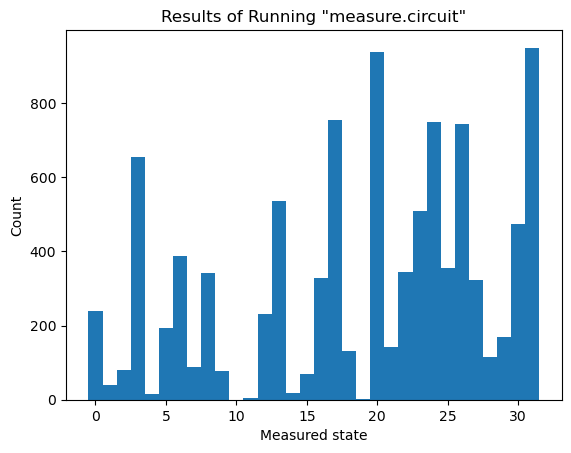

In [404]:
## Running measure.circuit and plotting results
measure_computer = Quantum_Computer("measure.circuit", True)
PrettyPrintInteger(measure_computer.run(initial_state=myInputState, print_m=True, num_measures=1))
def plot_measure_results():
    measure_computer.run(initial_state=myInputState, num_measures=10000)
    results = [int(result, 2) for result in measure_computer.get_measurements()[1][1]]

    types = []
    [types.append(x) for x in results if x not in types]
    counts = [results.count(value) for value in types]

    plt.figure()
    plt.bar(types, counts, width=1)
    plt.title(f"Results of Running \"measure.circuit\"")
    plt.xlabel("Measured state")
    plt.ylabel("Count")
    plt.show()
plot_measure_results()

In [294]:
## Running input.circuit
PrettyPrintInteger(Quantum_Computer("input.circuit", True).run())

{ (0.1541-0.03902j) |0> + (0.04895-0.03002j) |1> + (-0.02132+0.08775j) |2> + (-0.11161-0.23333j) |3> + (-0.0339-0.00967j) |4> + (-0.01675-0.13027j) |5> + (-0.19592+0.00989j) |6> + (-0.09796+0.01348j) |7> + (-0.18083+0.01438j) |8> + (0.05383-0.06863j) |9> + (0.00103-0.00346j) |10> + (-0.02154+0.01745j) |11> + (-0.0072+0.15958j) |12> + (-0.2231+0.07463j) |13> + (-0.03789+0.00586j) |14> + (0.0739-0.05074j) |15> + (-0.14805+0.08746j) |16> + (-0.06329+0.25662j) |17> + (0.11691+0.01381j) |18> + (-0.02668-0.00406j) |19> + (0.21923-0.21304j) |20> + (-0.04894-0.11636j) |21> + (-0.14794-0.10481j) |22> + (0.22317+0.05083j) |23> + (-0.13964-0.2372j) |24> + (0.18475-0.00515j) |25> + (-0.26322-0.0656j) |26> + (0.1752-0.02011j) |27> + (0.1122+0.00125j) |28> + (0.02419-0.12445j) |29> + (-0.2083+0.07702j) |30> + (0.05477+0.30613j) |31>}


In [295]:
## Phase estimation circuit description with 1 measurement wire
def PhaseE_D1(phi):
    return f"""2
INITSTATE BASIS |01>
H 0
CPHASE 0 1 {phi}
H 0
MEASURE"""

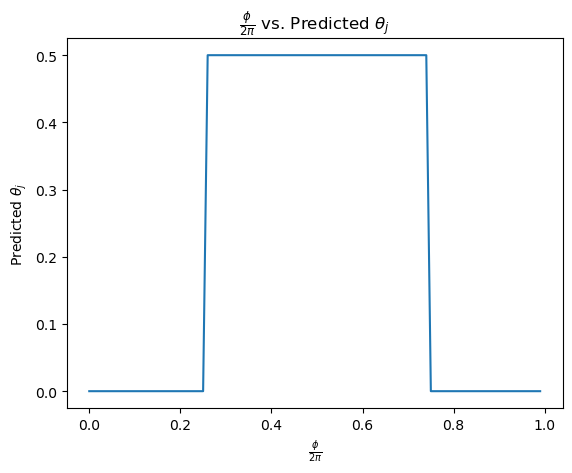

In [296]:
## Plotting predicted phase vs actual phase on 1 wire
def PhaseE_D1_G1():
    phi_by_2pi = np.linspace(0, 0.99, 100)
    theta_j = []
    for i in phi_by_2pi:
        desc = PhaseE_D1(2*m.pi*i)
        results = Quantum_Computer(desc).run()
        max_val = 0
        fin_state = 0
        for result in results:
            prob = result[0].real
            if prob > max_val:
                max_val = prob
                fin_state = result[1][0]
        theta = (0.5) * int(fin_state)
        theta_j.append(theta)

    plt.figure()
    plt.plot(phi_by_2pi, theta_j)
    plt.title(r"$\frac{\phi}{2\pi}$ vs. Predicted $\theta_j$")
    plt.xlabel(r"$\frac{\phi}{2\pi}$")
    plt.ylabel(r"Predicted $\theta_j$")
    plt.show()
PhaseE_D1_G1()

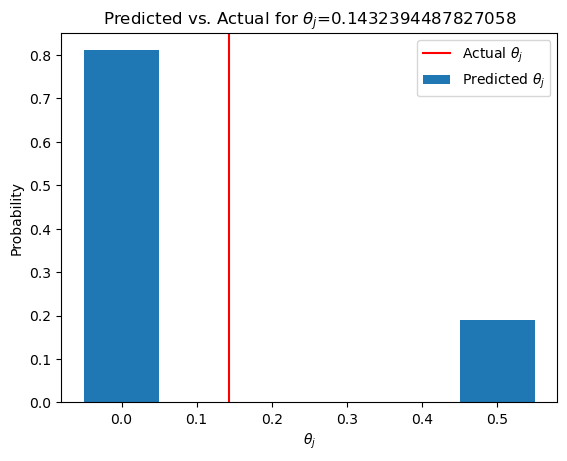

In [297]:
## Plotting phase measurements with 1 wire
def PhaseE_D1_G2():
    phi_by_2pi_set = 0.1432394487827058
    computer = Quantum_Computer(PhaseE_D1(2*m.pi*phi_by_2pi_set))
    computer.run(num_measures=10000)
    results = computer.get_last_measurement()[1]
    thetas = []
    for i in range(len(results)):
        if results[i] == '01':
            thetas.append(0)
        elif results[i] == '11':
            thetas.append(0.5)
    types = []
    [types.append(x) for x in thetas if x not in types]
    probs = [thetas.count(value)/len(thetas) for value in types]

    plt.figure()
    plt.bar(types, probs, width=0.1, label = r'Predicted $\theta_j$')
    plt.axvline(x = phi_by_2pi_set, color = 'r', label = r'Actual $\theta_j$')
    plt.title(r"Predicted vs. Actual for $\theta_j$=0.1432394487827058")
    plt.xlabel(r"$\theta_j$")
    plt.ylabel("Probability")
    plt.legend()
    plt.show()
PhaseE_D1_G2()

In [298]:
## Animating the previous graph with changing actual phase
def animation1():
    n_frames = 100
    print(n_frames)
    phi_by_2pi = np.linspace(0, 1, n_frames)
    computer = Quantum_Computer(PhaseE_D1(2*m.pi*phi_by_2pi[1]))
    computer.run(num_measures=1000)
    results = computer.get_last_measurement()[1]
    thetas = []
    for i in range(len(results)):
        if results[i] == '01':
            thetas.append(0)
        elif results[i] == '11':
            thetas.append(0.5)
    types = []
    [types.append(x) for x in thetas if x not in types]
    probs = [thetas.count(value)/len(thetas) for value in types]

    fig, ax = plt.subplots()
    bars = plt.bar(types, probs, width=0.1, label = r'Predicted $\theta_j$')
    line = plt.axvline(x = phi_by_2pi[1], color = 'r', label = r'Actual $\theta_j$')
    plt.title(r"Predicted vs. Actual for $\theta_j$")
    plt.xlabel(r"$\theta_j$")
    plt.ylabel("Probability")
    plt.xlim(-0.1, 1.1)
    plt.ylim(0, 1)
    plt.legend()

    def update(i):
        computer = Quantum_Computer(PhaseE_D1(2*m.pi*phi_by_2pi[i]))
        computer.run(num_measures=10000)
        results = computer.get_last_measurement()[1]
        thetas = []
        for j in range(len(results)):
            if results[j] == '01':
                thetas.append(0)
            elif results[j] == '11':
                thetas.append(0.5)
        types = []
        [types.append(x) for x in thetas if x not in types]
        probs = [thetas.count(value)/len(thetas) for value in types]
        plt.cla()
        bars = plt.bar(types, probs, width=0.1, label = r'Predicted $\theta_j$')
        line = plt.axvline(x = phi_by_2pi[i], color = 'r', label = r'Actual $\theta_j$')
        plt.title(r"Predicted vs. Actual for $\theta_j$")
        plt.xlabel(r"$\theta_j$")
        plt.ylabel("Probability")
        plt.xlim(-0.1, 1.1)
        plt.ylim(0, 1)
        plt.legend(loc='upper right')
        return [bars], [line]

    anim = FuncAnimation(fig, update, frames=n_frames, interval = 1, repeat=True, cache_frame_data=True)
    anim.save("thetaprediction1wire.gif")
    plt.show()
# animation1()

In [299]:
## Phase estimation circuit description with 2 measurement wires
def PhaseE_D2(phi):
    return f"""3
INITSTATE BASIS |001>
H 0
H 1
CPHASE 1 2 {phi}
CPHASE 0 2 {phi}
CPHASE 0 2 {phi}
H 0
CPHASE 0 1 {-m.pi/2}
H 1
SWAP 0 1
MEASURE"""

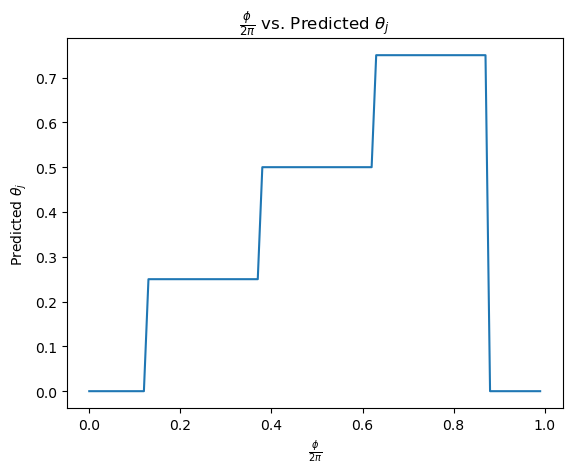

In [300]:
## Plotting predicted phase vs actual phase on 2 wires 
def PhaseE_D2_G1():
    phi_by_2pi = np.linspace(0, 0.99, 100)
    theta_j = []
    for i in phi_by_2pi:
        desc = PhaseE_D2(2*m.pi*i)
        results = Quantum_Computer(desc).run()
        max_val = 0
        fin_state = 0
        for result in results:
            prob = result[0].real
            if prob > max_val:
                max_val = prob
                fin_state = result[1][:-1]
        theta = (0.5) * int(fin_state[0]) + (0.25) * int(fin_state[1])
        theta_j.append(theta)

    plt.figure()
    plt.plot(phi_by_2pi, theta_j)
    plt.title(r"$\frac{\phi}{2\pi}$ vs. Predicted $\theta_j$")
    plt.xlabel(r"$\frac{\phi}{2\pi}$")
    plt.ylabel(r"Predicted $\theta_j$")
    plt.show()
PhaseE_D2_G1()

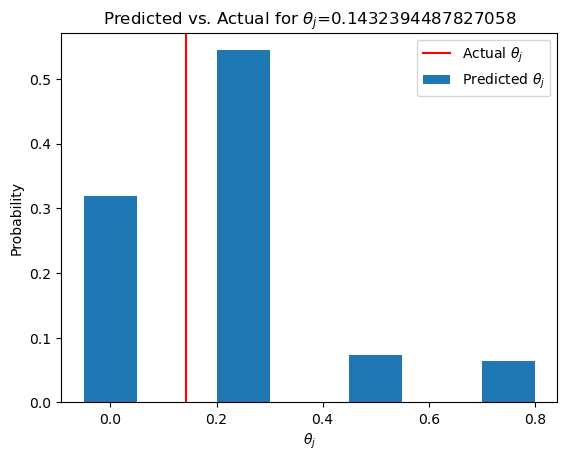

In [301]:
## Plotting phase measurements with 2 wires
def PhaseE_D2_G2():
    phi_by_2pi_set = 0.1432394487827058
    computer = Quantum_Computer(PhaseE_D2(2*m.pi*phi_by_2pi_set))
    computer.run(num_measures=10000)
    results = computer.get_last_measurement()[1]
    thetas = []
    for i in range(len(results)):
        result = results[i][:-1]
        thetas.append((0.5) * int(result[0]) + (0.25) * int(result[1]))
    types = []
    [types.append(x) for x in thetas if x not in types]
    probs = [thetas.count(value)/len(thetas) for value in types]

    plt.figure()
    plt.bar(types, probs, width=0.1, label = r'Predicted $\theta_j$')
    plt.axvline(x = phi_by_2pi_set, color = 'r', label = r'Actual $\theta_j$')
    plt.title(r"Predicted vs. Actual for $\theta_j$=0.1432394487827058")
    plt.xlabel(r"$\theta_j$")
    plt.ylabel("Probability")
    plt.legend()
    plt.show()
PhaseE_D2_G2()

In [302]:
## Animating the previous graph with changing actual phase
def animation2():
    n_frames = 200
    print(n_frames)
    phi_by_2pi = np.linspace(0, 1, n_frames)
    computer = Quantum_Computer(PhaseE_D2(2*m.pi*phi_by_2pi[1]))
    computer.run(num_measures=1000)
    results = computer.get_last_measurement()[1]
    thetas = []
    for i in range(len(results)):
        result = results[i][:-1]
        thetas.append((0.5) * int(result[0]) + (0.25) * int(result[1]))
    types = []
    [types.append(x) for x in thetas if x not in types]
    probs = [thetas.count(value)/len(thetas) for value in types]

    fig, ax = plt.subplots()
    bars = plt.bar(types, probs, width=0.1, label = r'Predicted $\theta_j$')
    line = plt.axvline(x = phi_by_2pi[1], color = 'r', label = r'Actual $\theta_j$')
    plt.title(r"Predicted vs. Actual for $\theta_j$")
    plt.xlabel(r"$\theta_j$")
    plt.ylabel("Probability")
    plt.xlim(-0.1, 1.1)
    plt.ylim(0, 1)
    plt.legend()

    def update(i):
        computer = Quantum_Computer(PhaseE_D2(2*m.pi*phi_by_2pi[i]))
        computer.run(num_measures=10000)
        results = computer.get_last_measurement()[1]
        thetas = []
        for j in range(len(results)):
            result = results[j][:-1]
            thetas.append((0.5) * int(result[0]) + (0.25) * int(result[1]))
        types = []
        [types.append(x) for x in thetas if x not in types]
        probs = [thetas.count(value)/len(thetas) for value in types]
        plt.cla()
        bars = plt.bar(types, probs, width=0.1, label = r'Predicted $\theta_j$')
        line = plt.axvline(x = phi_by_2pi[i], color = 'r', label = r'Actual $\theta_j$')
        plt.title(r"Predicted vs. Actual for $\theta_j$")
        plt.xlabel(r"$\theta_j$")
        plt.ylabel("Probability")
        plt.xlim(-0.1, 1.1)
        plt.ylim(0, 1)
        plt.legend(loc='upper right')
        return [bars], [line]

    anim = FuncAnimation(fig, update, frames=n_frames, interval = 10, repeat=True, cache_frame_data=True)
    anim.save("thetaprediction2wires.gif")
    plt.show()
# animation2()

In [303]:
## Circuit description generator for Quantum Fourier Transform on n wires
def QFT(n):
    st = ""
    for i in range(n):
        st += f"H {n-i-1}"
        for j in range(n-i-1):
            st += f"\nCPHASE {n-i-1} {n-i-1-j-1} {m.pi/(2**(j+1))}"
        st += "\n"
    return st[:-1]

## Circuit description generator for phase_estimation on n wires
## Defaults to U=CPHASE . . {PHI}, can take custom U 
def phase_estimator(n, phi=0, custom_description=""):
    basis0, basis1 = "", ""
    is_custom = len(custom_description)>0
    for i in range(n):
        basis0 += "0"
    n2 = 1
    basis1 = '1'
    if is_custom:
        n2, basis1, dummy = process_U_description(custom_description, 0, n)
    st = f"""{n+n2}\nINITSTATE BASIS |{basis0}{basis1}>\n"""
    for i in range(n):
        st+=f"H {i}\n"
    if is_custom:
        for i in range(n):
            for j in range(2**i):
                n2, basis1, des = process_U_description(custom_description, n-1-i, n)
                st+=f"{des}\n"
    else:
        for i in range(n):
            st+=f"CPHASE {n-1-i} {n} {2**i*phi}\n"
    st += f"{invert_description(QFT(n))}\n"
    st += f"{REVERSE(0, n)}\n"
    st += "MEASURE"
    return st

## Helper function to process custom U descriptions
def process_U_description(description, control, n):
    lines = description.splitlines(False)
    start = 1
    n2 = int(lines[0])
    if len(lines) > 1 and lines[1].split(' ')[0] == "INITSTATE":
        break_one = lines[1].split(' ')
        lower_state = break_one[2][1:-1]
        start += 1
    else:
        lower_state = ""
        for i in range(n2-1):
            lower_state += "0"
        lower_state += "1"
    st = ""
    for line in lines:
        pcs = line.split(' ')
        if pcs[0] == 'P':
            st += f"{CPHASE(control, n+int(pcs[1]), float(pcs[2]))}\n"
        elif pcs[0] == 'NOT':
            st += f"CNOT {control} {n+int(pcs[1])}\n"
    return n2, lower_state, st[:-1]

In [304]:
## Testing QFT on 3 wires
QFT_description = f"""3
INITSTATE BASIS |001>
REVERSE 0 3
{QFT(3)}"""
QFT_test_computer = Quantum_Computer(QFT_description, print_circuit=True)
state = QFT_test_computer.run()
PrettyPrintInteger(state)

3
INITSTATE BASIS |001>
REVERSE 0 3
H 2
CPHASE 2 1 1.5707963267948966
CPHASE 2 0 0.7853981633974483
H 1
CPHASE 1 0 1.5707963267948966
H 0
{ (0.35355+0j) |0> + (0.25+0.25j) |1> + 0.35355j |2> + (-0.25+0.25j) |3> + (-0.35355+0j) |4> + (-0.25-0.25j) |5> + -0.35355j |6> + (0.25-0.25j) |7>}


In [305]:
## Testing QFT on 5 wires
QFT_description = f"""5
INITSTATE FILE myInputState.txt
REVERSE 0 4
{QFT(5)}"""
QFT_test_computer = Quantum_Computer(QFT_description, print_circuit=True)
state = QFT_test_computer.run()
print(state)

5
INITSTATE FILE myInputState.txt
REVERSE 0 4
H 4
CPHASE 4 3 1.5707963267948966
CPHASE 4 2 0.7853981633974483
CPHASE 4 1 0.39269908169872414
CPHASE 4 0 0.19634954084936207
H 3
CPHASE 3 2 1.5707963267948966
CPHASE 3 1 0.7853981633974483
CPHASE 3 0 0.39269908169872414
H 2
CPHASE 2 1 1.5707963267948966
CPHASE 2 0 0.7853981633974483
H 1
CPHASE 1 0 1.5707963267948966
H 0
[[(-0.04028-0.22092j), '00000'], [(-0.09575-0.07382j), '00001'], [(0.15632+0.15387j), '00010'], [(-0.0988+0.01736j), '00011'], [(0.2052+0.01736j), '00100'], [(-0.09343+0.06486j), '00101'], [(0.03687-0.11028j), '00110'], [(0.08211-0.39124j), '00111'], [(0.12581-0.03562j), '01000'], [(0.08068+0.09396j), '01001'], [(0.08372-0.24708j), '01010'], [(-0.05084+0.04454j), '01011'], [(-0.00613-0.0884j), '01100'], [(-0.12216-0.21366j), '01101'], [(0.06886-0.11625j), '01110'], [(0.16715+0.11573j), '01111'], [(0.0512-0.14919j), '10000'], [(-0.08131+0.09101j), '10001'], [(-0.03807-0.08061j), '10010'], [(-0.20995+0.18541j), '10011'], [(-0

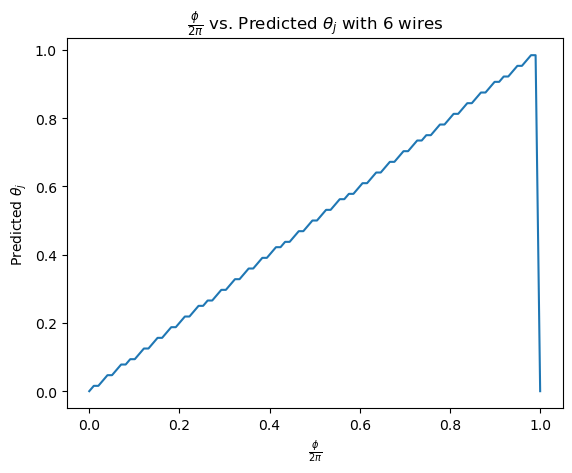

In [306]:
## Plotting predicted phase vs actual phase on n wires
def PhaseE_G1_Generator(n):
    phi_by_2pi = np.linspace(0, 1, 100)
    theta_j = []
    for i in phi_by_2pi:
        desc = phase_estimator(n, phi=2*m.pi*i)
        results = Quantum_Computer(desc).run()
        max_val = 0
        fin_state = 0
        for result in results:
            prob = abs(result[0])**2
            if prob > max_val:
                max_val = prob
                fin_state = result[1][:-1]
        theta = 0
        for j in range(n):
            theta += (1/2)**(j+1)*int(fin_state[j])
        theta_j.append(theta)
        
    plt.figure()
    plt.plot(phi_by_2pi, theta_j)
    plt.title(r"$\frac{\phi}{2\pi}$ vs. Predicted $\theta_j$ with" + f" {n} wires")
    plt.xlabel(r"$\frac{\phi}{2\pi}$")
    plt.ylabel(r"Predicted $\theta_j$")
    plt.show()
PhaseE_G1_Generator(6)

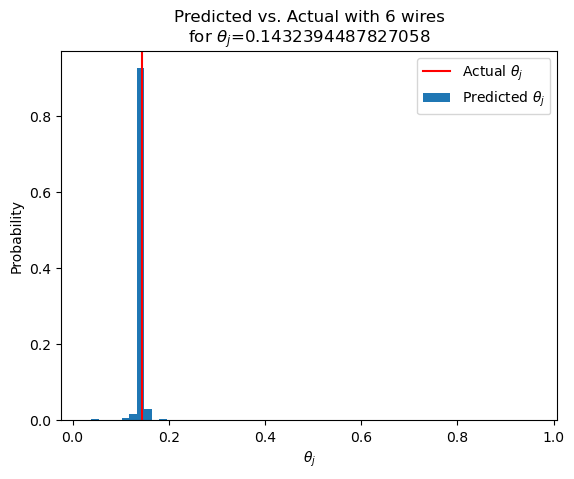

In [307]:
## Plotting phase measurements with n wires
def PhaseE_G2_Generator(n, num_measures=1000):
    phi_by_2pi_set = 0.1432394487827058
    desc = phase_estimator(n, phi=2*m.pi*phi_by_2pi_set)
    computer = Quantum_Computer(desc)
    computer.run(num_measures=num_measures)
    results = computer.get_last_measurement()[1]
    thetas = []
    for i in range(len(results)):
        result = results[i][:-1]
        theta = 0
        for j in range(n):
            theta += (1/2)**(j+1)*int(result[j])
        thetas.append(theta)
    types = []
    [types.append(x) for x in thetas if x not in types]
    probs = [thetas.count(value)/len(thetas) for value in types]

    width = 1/2**n
    if width > 0.1: width = 0.1
    plt.figure()
    plt.bar(types, probs, width=width, label = r'Predicted $\theta_j$')
    plt.axvline(x = phi_by_2pi_set, color = 'r', label = r'Actual $\theta_j$')
    plt.title(f"Predicted vs. Actual with {n} wires\n" + r"for $\theta_j$=0.1432394487827058")
    plt.xlabel(r"$\theta_j$")
    plt.ylabel("Probability")
    plt.legend()
    plt.show()
PhaseE_G2_Generator(6)

In [308]:
## Animating the previous graph for n wires
def PhaseE_G2_Animation_Generator(n, n_frames=200, time=2, num_measures=10000):
    phi_by_2pi = np.linspace(0, 1, n_frames)
    computer = Quantum_Computer(phase_estimator(n, 2*m.pi*phi_by_2pi[1]))
    computer.run(num_measures=num_measures)
    results = computer.get_last_measurement()[1]
    thetas = []
    for j in range(len(results)):
        result = results[j][:-1]
        theta = 0
        for k in range(n):
            theta += (1/2)**(k+1)*int(result[k])
        thetas.append(theta)
    types = []
    [types.append(x) for x in thetas if x not in types]
    probs = [thetas.count(value)/len(thetas) for value in types]

    width = 1/2**n
    if width > 0.1: width = 0.1
    fig, ax = plt.subplots()
    bars = plt.bar(types, probs, width=width, label = r'Predicted $\theta_j$')
    line = plt.axvline(x = phi_by_2pi[1], color = 'r', label = r'Actual $\theta_j$')
    plt.title(r"Predicted vs. Actual for $\theta_j$" + f"\nWith {n} Wires")
    plt.xlabel(r"$\theta_j$")
    plt.ylabel("Probability")
    plt.xlim(-0.1, 1.1)
    plt.ylim(0, 1)
    plt.legend()
    
    def update(i):
        computer = Quantum_Computer(phase_estimator(n, 2*m.pi*phi_by_2pi[i]))
        computer.run(num_measures=num_measures)
        results = computer.get_last_measurement()[1]
        thetas = []
        for j in range(len(results)):
            result = results[j][:-1]
            theta = 0
            for k in range(n):
                theta += (1/2)**(k+1)*int(result[k])
            thetas.append(theta)
        types = []
        [types.append(x) for x in thetas if x not in types]
        probs = [thetas.count(value)/len(thetas) for value in types]
        plt.cla()
        bars = plt.bar(types, probs, width=width, label = r'Predicted $\theta_j$')
        line = plt.axvline(x = phi_by_2pi[i], color = 'r', label = r'Actual $\theta_j$')
        plt.title(r"Predicted vs. Actual for $\theta_j$" + f"\nWith {n} Wires")
        plt.xlabel(r"$\theta_j$")
        plt.ylabel("Probability")
        plt.xlim(-0.1, 1.1)
        plt.ylim(0, 1)
        plt.legend(loc='upper right')
        return [bars], [line]

    anim = FuncAnimation(fig, update, frames=n_frames, interval = time*1000/n_frames, repeat=True, cache_frame_data=True)
    anim.save(f"thetaprediction{n}wires_gen.gif")
    plt.show()
# PhaseE_G2_Animation_Generator(6, n_frames=1000, time=5)

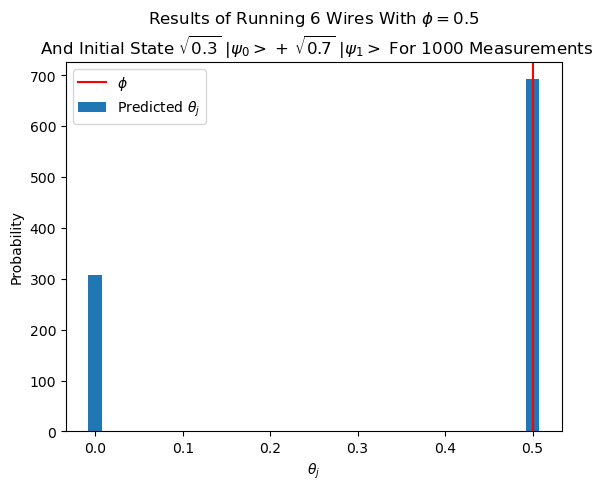

In [309]:
## Plotting predicted phase with input as a superposition of two states
def PhaseE_G3_Generator(num_measures=1000):
    n = 6
    phi_by_2pi_set = 0.5
    desc = phase_estimator(n, phi=2*m.pi*phi_by_2pi_set)
    computer = Quantum_Computer(desc)
    vec = np.zeros(2**(n+1))
    vec[0] = m.sqrt(0.3)
    vec[1] = m.sqrt(0.7)
    computer.run(initial_state=VecToState(vec), num_measures=num_measures)
    results = [result[:-1] for result in computer.get_measurements()[0][1]]

#     types = []
#     [types.append(x) for x in results if x not in types]
#     counts = [results.count(value) for value in types]

#     plt.figure()
#     plt.bar(types, counts, width=1)
#     plt.title(f"Results of Running {n} wires with " + r"$\phi = 0.5$ and initial state $\sqrt(0.3)|\phi_1")
#     plt.xlabel("Measured state")
#     plt.ylabel("Count")
#     plt.show()
    thetas = []
    for result in results:
        theta = 0
        for j in range(n):
            theta += (1/2)**(j+1)*int(result[j])
        thetas.append(theta)
    types = []
    [types.append(x) for x in thetas if x not in types]
    count = [thetas.count(value) for value in types]

    width = 1/2**n
    if width > 0.1: width = 0.1
    plt.figure()
    plt.bar(types, count, width=width, label = r'Predicted $\theta_j$')
    plt.axvline(x = phi_by_2pi_set, color = 'r', label = r'$\phi$')
    plt.title(f"Results of Running {n} Wires With " + r"$\phi = 0.5$" + "\n"+ r" And Initial State $\sqrt{0.3}$ |$\psi_0>$ + $\sqrt{0.7}$ |$\psi_1>$ For 1000 Measurements")
    plt.xlabel(r"$\theta_j$")
    plt.ylabel("Probability")
    plt.legend()
    plt.show()
PhaseE_G3_Generator()

In [310]:
## Custom U description for phase estimation
custom_description1 = f"""1
P 0 {(0.3)*2*m.pi}
NOT 0
P 0 {(0.7)*2*m.pi}
NOT 0"""

In [311]:
## Custom U description for phase estimation
custom_description2 = f"""2
P 0 {2*m.pi*0.3}
NOT 0
P 0 {2*m.pi*0.7}
NOT 0
NOT 1"""

In [312]:
## Print circuit description for custom phase estimator (commented out because the output is long)
# print(phase_estimator(6, is_custom=True, custom_description=custom_description1))

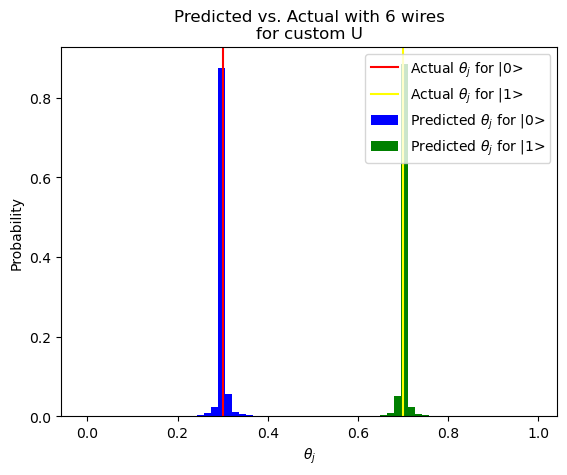

In [313]:
## Plotting the predicted phase for the custom description given either input |0> or |1>
def custom_description_PhaseE():
    n = 6
    computer1 = Quantum_Computer(phase_estimator(6, custom_description=custom_description1))
    computer1.run(num_measures=10000)
    results1 = computer1.get_last_measurement()[1]
    thetas1 = []
    for i in range(len(results1)):
        result = results1[i][:-1]
        theta = 0
        for j in range(n):
            theta += (1/2)**(j+1)*int(result[j])
        thetas1.append(theta)
    types1 = []
    [types1.append(x) for x in thetas1 if x not in types1]
    probs1 = [thetas1.count(value)/len(thetas1) for value in types1]

    vec = np.zeros(2**(n+1))
    vec[0] = 1
    computer2 = Quantum_Computer(phase_estimator(6, custom_description=custom_description1))
    computer2.run(num_measures=10000, initial_state=VecToState(vec))
    results2 = computer2.get_last_measurement()[1]
    thetas2 = []
    for i in range(len(results2)):
        result = results2[i][:-1]
        theta = 0
        for j in range(n):
            theta += (1/2)**(j+1)*int(result[j])
        thetas2.append(theta)
    types2 = []
    [types2.append(x) for x in thetas2 if x not in types2]
    probs2 = [thetas2.count(value)/len(thetas2) for value in types2]

    width = 1/2**n
    if width > 0.1: width = 0.1
    plt.figure()
    plt.bar(types1, probs1, width=width, color = "blue", label = r'Predicted $\theta_j$ for |0>')
    plt.bar(types2, probs2, width=width, color="g", label = r'Predicted $\theta_j$ for |1>')
    plt.axvline(x = 0.3, color = 'r', label = r'Actual $\theta_j$ for |0>')
    plt.axvline(x = 0.7, color = 'yellow', label = r'Actual $\theta_j$ for |1>')

    plt.title(f"Predicted vs. Actual with {n} wires\n" + r"for custom U")
    plt.xlabel(r"$\theta_j$")
    plt.ylabel("Probability")
    plt.legend()
    plt.show()
custom_description_PhaseE()

In [314]:
## Classical Shor's, takes int n and returns two factors
def Shor(n, return_error=False):
    e1, e2 = 0, 0
    if n <= 1:
        print(f"{n} shouldn't be here")
        if return_error: return e1, e2
        return n, n
    if sympy.isprime(n):
        if return_error: return e1, e2
        return -1, -1
    if n % 2 == 0:
        factor = int(n/2)
        if return_error: return e1, e2
        return 2, factor
    for a in range(2, int(m.log2(n))):
        if (n**(1/a)).is_integer():
            if return_error: return e1, e2
            return int(n**(1/a)), int(n/(n**(1/a)))
    rng = np.random.default_rng()
    while 0<1:
        x = int(rng.integers(1, n))
        if m.gcd(x, n) != 1:
            if return_error: return e1, e2
            return int(m.gcd(x, n)), int(n/m.gcd(x, n))
        r = 2
        while x**r % n != 1:
            if (r>n):
                print(f"r = {r} > n = {n}")
                raise ValueError()
            r+=1
        if r % 2 != 0:
            e1 += 1
            continue
        f1 = int(m.gcd(int((x**int(r/2)+1) % n), n))
        f2 = int(m.gcd(int((x**int(r/2)-1) % n), n))
        if f1 == 1 or f2 == 1 or f1 == n or f2 == n:
            e2+=1
            continue
#         print(f"For N = {n}: x = {x}, r = {r}")
        if return_error: return e1, e2
        return f1, f2
    
## Iterates classical Shor's to return all factors
def full_factorization(n):
    if not isinstance(n, int):
        print("bitch")
        return Quantum_Computer("1\nH 0")
    if n < 0:
        print(f"heyyyyyyy, why you do this to mee :(")
        print(f"Well fuck you anyway I'm making it positive")
        print(f"number = {-n}")
        n = -n
    if sympy.isprime(n) or n <= 1:
        print(f"{n} is a prime number silly!")
        return n
    factors = []
    non_prime = [n]
    while len(non_prime) != 0:
        for i in range(len(non_prime)): 
#             t.sleep(0.05)
            num = non_prime.pop()
            n1, n2 = Shor(num)
            if n1 == -1 and n2 == -1:
                print(f"Yay! Found factor {num} :)")
                factors.append(num)
            else:
                non_prime.append(n1)
                non_prime.append(n2)
    return factors

In [240]:
## Testing Shor's
nums = [15, 21]
for num in nums:
    n1, n2 = Shor(num)
    print(f"Factors of {num} are {n1} and {n2}")

Factors of 15 are 3 and 5
Factors of 21 are 3 and 7


In [241]:
## Testing Shor's at large n
number = 12740
print(f"Factors are: {full_factorization(number)}")

Yay! Found factor 7 :)
Yay! Found factor 7 :)
Yay! Found factor 13 :)
Yay! Found factor 5 :)
Yay! Found factor 2 :)
Yay! Found factor 2 :)
Factors are: [7, 7, 13, 5, 2, 2]


In [242]:
## Recording runtime and error rates in Shor's
import time as t
execute_times = []
e1s = []
e2s = []
for k in range(2, 7500):
    start = t.time()
    e1, e2 = Shor(k, return_error = True)
    stop = t.time()
    execute_times.append(stop-start)
    e1s.append(e1)
    e2s.append(e2)

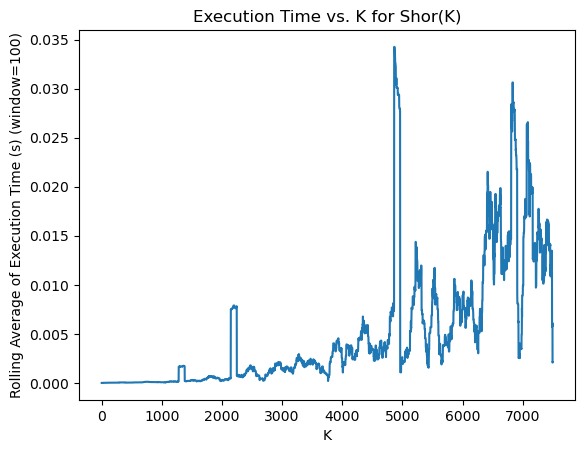

In [409]:
## Plotting runtime vs. K for Shor(K)
window = 100
plt.figure()
plt.plot(rolling_avg(execute_times, window))
plt.xlabel("K")
plt.ylabel(f"Rolling Average of Execution Time (s) (window={window})")
plt.title("Execution Time vs. K for Shor(K)")
plt.show()

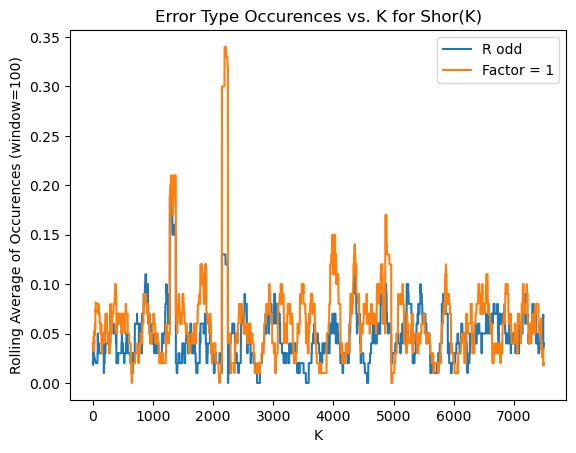

In [244]:
## Plotting error rates in Shor's vs. K
window = 100
plt.figure()
# plt.plot(rolling_avg(execute_times, 100))
plt.plot(rolling_avg(e1s, window), label = "R odd")
plt.plot(rolling_avg(e2s, window), label = "Factor = 1")
plt.xlabel("K")
plt.ylabel(f"Rolling Average of Occurences (window={window})")
plt.title("Error Type Occurences vs. K for Shor(K)")
plt.legend()
plt.show()

In [353]:
## Create a unitary for x and N
def Unitary_Matrix(x, N):
    n = m.ceil(m.log2(N))
    mat = np.eye(2**n)
    mat[:N, :N] = 0
    for y in range(0, N):
        idx = x*y % N
        mat[y, idx] = 1
    return mat
print(Unitary_Matrix(3, 5))

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


In [365]:
## Test U
Ns = [15, 15, 15, 15, 15, 21, 21, 21, 21, 21]
xs = [2, 4, 8, 11, 13, 2, 8, 10, 11, 13]
rs = [4, 2, 4, 2, 4, 6, 2, 6, 6, 2]
for i in range(1):
    x, N = xs[i], Ns[i]
    mat = Unitary_Matrix(x, N)
    vals, vecs = np.linalg.eig(mat)
    phases = [cm.phase(val)/(2*m.pi) for val in vals]
    times_r = [phase*rs[i] for phase in phases]
    print(f"x = {xs[i]}, N = {Ns[i]}, r = {rs[i]}")
    print(f"Values:\n{phases}")
    print(f"e*r:\n{times_r}\n")

x = 2, N = 15, r = 4
Values:
[0.5, 0.25, -0.25, 0.0, 0.5, 0.25, -0.25, 0.0, 0.5, 0.25, -0.25, 0.0, 0.0, 0.5, 0.0, 0.0]
e*r:
[2.0, 1.0, -1.0, 0.0, 2.0, 1.0, -1.0, 0.0, 2.0, 1.0, -1.0, 0.0, 0.0, 2.0, 0.0, 0.0]



In [366]:
## Test U
Ns = [15, 15, 15, 15, 15, 21, 21, 21, 21, 21]
xs = [2, 4, 8, 11, 13, 2, 8, 10, 11, 13]
rs = [4, 2, 4, 2, 4, 6, 2, 6, 6, 2]
calc_r = []
for i in range(len(Ns)):
    x, N = xs[i], Ns[i]
    mat = Unitary_Matrix(x, N)
    vals, vecs = np.linalg.eig(mat)
    phases = [cm.phase(val)/(2*m.pi) for val in vals]
    r = 0
    r_max = 10
    tried = []
    while r == 0:
        fracs = [Fraction(theta).limit_denominator(r_max) for theta in phases]
        for frac in fracs:
            denom = frac.denominator
            if denom in tried:
                continue
            tried.append(denom)
            if x**denom%N == 1:
                r = denom
                continue
        if r_max > 5000:
            r = -1
        r_max = r_max+50
    calc_r.append(r)
print(calc_r)
print(rs)

[4, 2, 4, 2, 4, 6, 2, 6, 6, 2]
[4, 2, 4, 2, 4, 6, 2, 6, 6, 2]


In [361]:
## Shor's using Unitary_Matrix(x, N) to find r, takes int n and returns two factors
def Shor_U(n, return_error=False):
    e1, e2 = 0, 0
    if n <= 1:
        print(f"{n} shouldn't be here")
        if return_error: return e1, e2
        return n, n
    if sympy.isprime(n):
        if return_error: return e1, e2
        return -1, -1
    if n % 2 == 0:
        factor = int(n/2)
        if return_error: return e1, e2
        return 2, factor
    for a in range(2, int(m.log2(n))):
        if (n**(1/a)).is_integer():
            if return_error: return e1, e2
            return int(n**(1/a)), int(n/(n**(1/a)))
    rng = np.random.default_rng()
    while 0<1:
        x = int(rng.integers(1, n))
        if m.gcd(x, n) != 1:
            if return_error: return e1, e2
            return int(m.gcd(x, n)), int(n/m.gcd(x, n))
        
        mat = Unitary_Matrix(x, N)
        vals, vecs = np.linalg.eig(mat)
        phases = [cm.phase(val)/(2*m.pi) for val in vals]
        r = 0
        r_max = 10
        tried = []
        while r == 0:
            fracs = [Fraction(theta).limit_denominator(r_max) for theta in phases]
            for frac in fracs:
                denom = frac.denominator
                if denom in tried:
                    continue
                tried.append(denom)
                if x**denom%N == 1:
                    r = denom
                    continue
            if r_max > 5000:
                r = -1
            r_max = r_max+50
        if r == -1:
            continue
        if r % 2 != 0:
            e1 += 1
            continue
        f1 = int(m.gcd(int((x**int(r/2)+1) % n), n))
        f2 = int(m.gcd(int((x**int(r/2)-1) % n), n))
        if f1 == 1 or f2 == 1 or f1 == n or f2 == n:
            e2+=1
            continue
#         print(f"For N = {n}: x = {x}, r = {r}")
        if return_error: return e1, e2
        return f1, f2

In [378]:
rng = np.random.default_rng()
xs = rng.integers(1, 1000, 10)
factors = [Shor_U(x) for x in xs]
print(xs)
print(factors)

[473 707  43 135 992 612 733 346 707 922]
[(11, 43), (7, 101), (-1, -1), (5, 9), (2, 496), (2, 306), (-1, -1), (2, 173), (7, 101), (2, 461)]


In [245]:
## Testing xyModN gate
x = 8; y = 3; N = 10;
description = f"""4
INITSTATE BASIS |0011>
FUNC 0 4 xyModN {x} {N}"""
print(f"Computer Result: {int(Quantum_Computer(description).run()[0][1],2)}")
print(f"Ground Result: {x*y%N}")

Computer Result: 4
Ground Result: 4


In [246]:
## Testing CxyModN gate
x = 7; y = 6; N = 10;
description = f"""5
INITSTATE BASIS |00110>
CFUNC 0 1 4 xyModN {x} {N}"""
print(f"Computer Result (control on): {int(Quantum_Computer(description).run(initial_state=[[1, '10110']])[0][1][1:],2)}")
print(f"Computer Result (control off): {int(Quantum_Computer(description).run()[0][1][1:],2)}")
print(f"Ground Result: {x*y%N}")

Computer Result (control on): 2
Computer Result (control off): 6
Ground Result: 2


In [247]:
## Testing phase estimation with CxyModN
def CxyModN_phase_estimator(n, n2, x, N, is_fast=False):
    basis0, basis1 = "", ""
    for i in range(n):
        basis0 += "0"
    for i in range(n2-1):
        basis1 += "0"
    basis1 += "1"
    st = f"""{n+n2}\nINITSTATE BASIS |{basis0}{basis1}>\n"""
    for i in range(n):
        st+=f"H {i}\n"
    if is_fast:
        for i in range(n):
            st+=f"CFUNC {n-1-i} {n} {n2} xyModN {x**(2**i)} {N}\n"
    else:
        for i in range(n):
            for j in range(2**i):
                st+=f"CFUNC {n-1-i} {n} {n2} xyModN {x} {N}\n"
    st += f"{invert_description(QFT(n))}\n"
    st += f"{REVERSE(0, n)}\n"
    st += "MEASURE"
    return st
computer = Quantum_Computer(CxyModN_phase_estimator(9, 4, 8, 15), print_circuit=False)
state = computer.run()
print(state)

[[(0.25+0j), '0000000000001'], [(0.25+0j), '0000000000010'], [(0.25+0j), '0000000000100'], [(0.25+0j), '0000000001000'], [(0.25+0j), '0100000000001'], [0.25j, '0100000000010'], [(-0.25+0j), '0100000000100'], [-0.25j, '0100000001000'], [(0.25+0j), '1000000000001'], [(-0.25+0j), '1000000000010'], [(0.25+0j), '1000000000100'], [(-0.25+0j), '1000000001000'], [(0.25+0j), '1100000000001'], [-0.25j, '1100000000010'], [(-0.25+0j), '1100000000100'], [0.25j, '1100000001000']]


In [183]:
## Shor's but using quantum
def Quantum_Shor(N, return_error=False, num_measures=1000, is_fast=False):
    start = t.time()
    e1, e2 = 0, 0
    bits = m.ceil(m.log2(N))
    if N <= 1:
        print(f"{N} shouldn't be here")
        if return_error: return e1, e2
        return N, N
    if sympy.isprime(N):
        if return_error: return e1, e2
        return -1, -1
    if N % 2 == 0:
        factor = int(N/2)
        if return_error: return e1, e2
        return 2, factor
    for a in range(2, bits):
        if (N**(1/a)).is_integer():
            if return_error: return e1, e2
            return int(N**(1/a)), int(N/(N**(1/a)))
    rng = np.random.default_rng()
    tried_x = []
    while 0<1:
        x = int(rng.integers(2, N))
        if x in tried_x: 
            continue
        tried_x.append(x)
        if m.gcd(x, N) != 1:
            if return_error: return e1, e2
            return int(m.gcd(x, N)), int(N/m.gcd(x, N))
        print(f"Entering quantum_find_r(x={x},N={N},bits={bits},num_measures={num_measures}): time = {t.time()-start}")
        r = quantum_find_r(x, N, bits, num_measures, is_fast)
        print(f"Found r = {r}: time = {t.time()-start}")
        if r == -1:
            print("r not found...trying again")
            continue
        if r % 2 != 0:
            e1 += 1
            continue
        f1 = int(m.gcd(int((x**int(r/2)+1) % N), N))
        f2 = int(m.gcd(int((x**int(r/2)-1) % N), N))
        if f1 == 1 or f2 == 1 or f1 == N or f2 == N:
            e2+=1
            continue
#         print(f"For N = {N}: x = {x}, r = {r}")
        if return_error: return e1, e2
        return f1, f2

## Quantum helper
def quantum_find_r(x, N, bits, num_measures=1000, is_fast=False):
    len_top = int(2*bits + 1)
    computer = Quantum_Computer(CxyModN_phase_estimator(len_top, bits, x, N, is_fast))
    computer.run(num_measures=num_measures)
    results = computer.get_measurements()[0][1]
    thetas = []
    for i in range(len(results)):
        result = results[i][:-bits]
        theta = 0
        for j in range(len_top):
            theta += (1/2)**(j+1)*int(result[j])
        # No rotation
        if theta != 0:
            thetas.append(theta)
    r = 0
    r_max = 10
    tried = []
    while r == 0:
        fracs = [Fraction(theta).limit_denominator(r_max) for theta in thetas]
        for frac in fracs:
            denom = frac.denominator
            if denom in tried:
                continue
            tried.append(denom)
            if x**denom%N == 1:
                r = denom
                continue
        if r_max > 5000:
            r = -1
        r_max = r_max+50
    return r

In [94]:
print(Quantum_Shor(15))

Entering quantum_find_r(x=7,N=15,bits=4,num_measures=1000): time = 0.000997304916381836
Found r = 4: time = 14.145654439926147
(5, 3)


In [ ]:
print(Quantum_Shor(21))

In [191]:
print(Quantum_Shor(15, is_fast=True))

Entering quantum_find_r(x=2,N=15,bits=4,num_measures=1000): time = 0.0
Found r = 4: time = 4.0312206745147705
(5, 3)


In [188]:
print(Quantum_Shor(21, is_fast=True))

Entering quantum_find_r(x=20,N=21,bits=5,num_measures=1000): time = 0.0
Found r = 2: time = 46.8257896900177
Entering quantum_find_r(x=11,N=21,bits=5,num_measures=1000): time = 46.8257896900177
Found r = 6: time = 102.50893640518188
(3, 7)


In [420]:
def addition_description(n, b):
    st = f"{n}\n"
    st += f"{REVERSE(0, n)}\n"
    st += f"{QFT(n)}\n"
    for i in range(n):
        st += f"P {i} {2*m.pi*b*2**(n-1-i)/2**n}\n"
    st += f"{invert_description(QFT(n))}\n"
    st += f"{REVERSE(0, n)}"
    return st
computer = Quantum_Computer(addition_description(4, 12))
print("3 + 12 =")
PrettyPrintInteger(computer.run(initial_state=[[1, '0011']]))

3 + 12 =
{ (1+0j) |15>}
